# Rice Data and Donuts Time Series Workshop Interactive Exercises: Python
####  Corrin Fosmire (Rice University)
#### August 1st, 2019

## Introduction

This notebook will run through a full forecasting modeling session, using real data from the Dow Jones Industrial Average. Let's get started!

## Exploration of Data

Let's begin by taking a look at our data and exploring some relationships.

In [1]:
import pandas as pd
from plotnine import *
from sklearn.linear_model import LinearRegression
import numpy as np
import datetime
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace import sarimax
from fbprophet import Prophet

djia = pd.read_csv("djiafixed.csv")
djia["Date"] = pd.to_datetime(djia["Date"])
djiaclean = djia.fillna(method='ffill')
djia = djia.fillna(method='ffill')

ERROR:fbprophet:Importing plotly failed. Interactive plots will not work.


In [2]:
djiaclean.head()

,rowid,year,month,yday,wday,mday,Date,Close
0,1,2013,1,2.0,4.0,2,2013-01-02,13412.549805
1,2,2013,1,3.0,5.0,3,2013-01-03,13391.360352
2,3,2013,1,4.0,6.0,4,2013-01-04,13435.209961
3,4,2013,1,4.0,6.0,5,2013-01-04,13384.290039
4,5,2013,1,4.0,6.0,6,2013-01-04,13384.290039


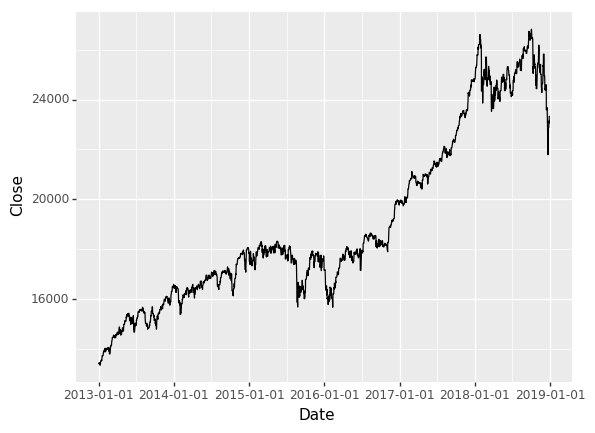

<ggplot: (-9223363264966226919)>

In [3]:
(ggplot(djiaclean) +
  geom_line(mapping=aes('Date', 'Close')))

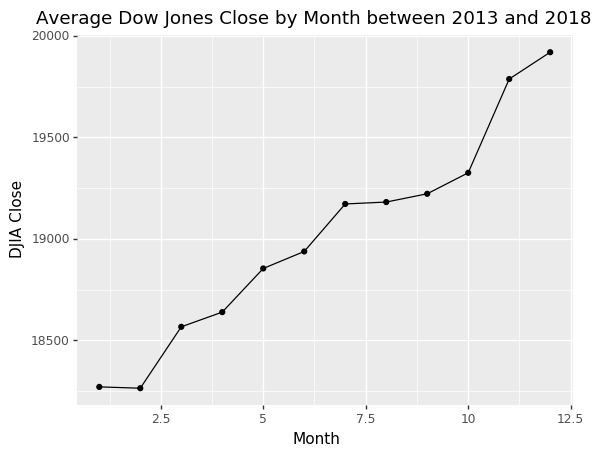

<ggplot: (8771938157597)>

In [4]:
daygroup = djiaclean.groupby('month').Close.agg('mean').reset_index()
(ggplot(daygroup) +
  geom_point(mapping=aes('month', 'Close')) +
  geom_line(mapping=aes('month', 'Close')) +
  labs(title="Average Dow Jones Close by Month between 2013 and 2018 ", y="DJIA Close", x="Month"))

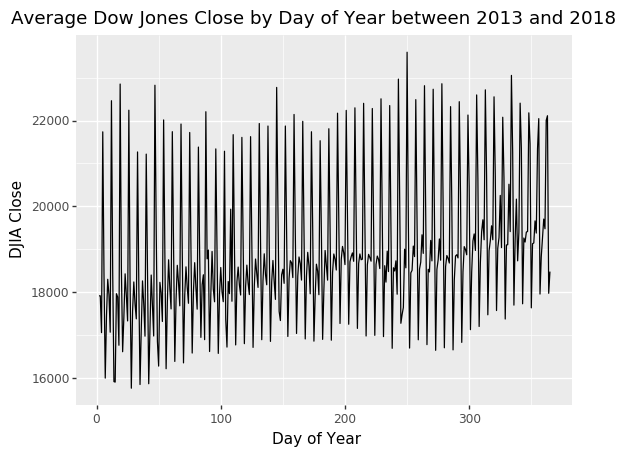

<ggplot: (8771879299262)>

In [5]:
daygroup = djiaclean.groupby('yday').Close.agg('mean').reset_index()
(ggplot(daygroup) +
  geom_line(mapping=aes('yday', 'Close')) +
  labs(title="Average Dow Jones Close by Day of Year between 2013 and 2018 ", y="DJIA Close", x="Day of Year"))

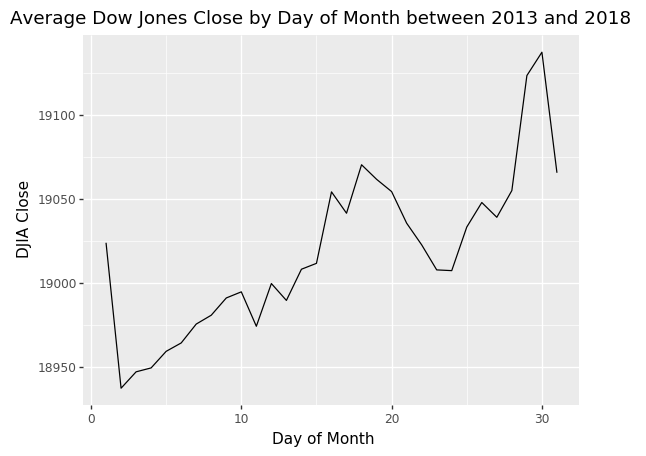

<ggplot: (8771879299171)>

In [6]:
daygroup = djiaclean.groupby('mday').Close.agg('mean').reset_index()
(ggplot(daygroup) +
  geom_line(mapping=aes('mday', 'Close')) +
  labs(title="Average Dow Jones Close by Day of Month between 2013 and 2018 ", y="DJIA Close", x="Day of Month"))

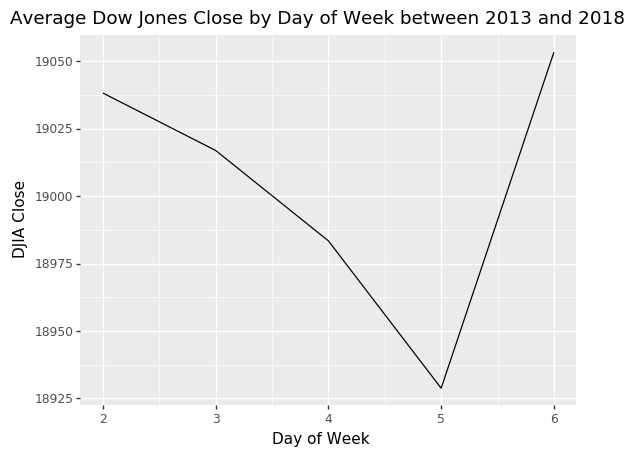

<ggplot: (8771888549089)>

In [7]:
daygroup = djiaclean.groupby('wday').Close.agg('mean').reset_index()
(ggplot(daygroup) +
  geom_line(mapping=aes('wday', 'Close')) +
  labs(title="Average Dow Jones Close by Day of Week between 2013 and 2018 ", y="DJIA Close", x="Day of Week"))

## Checking out the trend

We first fit an simple line of best fit model, just to give us an idea how the mean is changing over time.

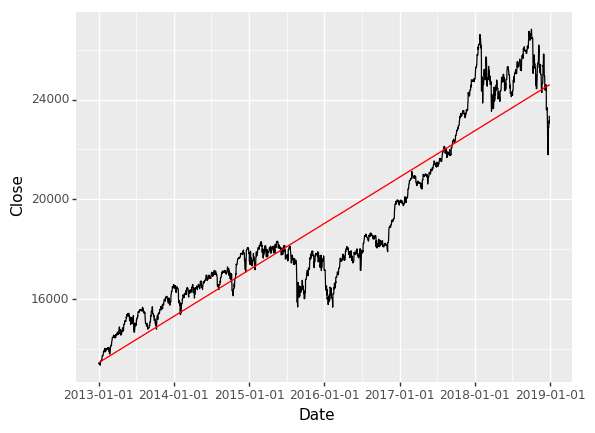

<ggplot: (-9223363264975546869)>

In [8]:
arraydata = np.reshape(np.array(djiaclean.rowid), (-1, 1))

trendmodel = LinearRegression().fit(arraydata, djiaclean.Close)
linearmodelpredictions = trendmodel.predict(arraydata)

(ggplot(djiaclean) +
  geom_line(mapping=aes('Date', 'Close')) +
  geom_line(mapping=aes('Date', linearmodelpredictions),color='red'))

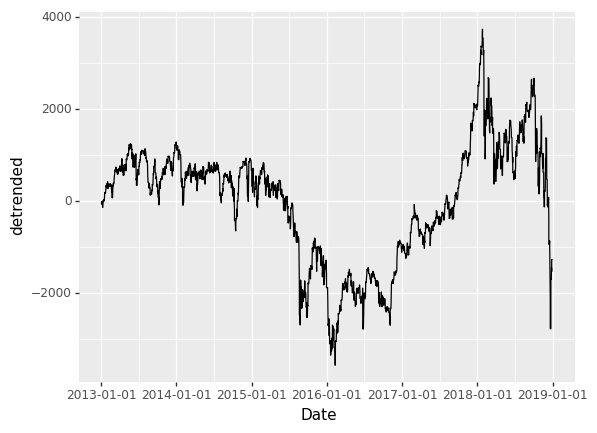

<ggplot: (8771879265989)>

In [9]:
djiaclean["detrended"] = djiaclean["Close"] - linearmodelpredictions

(ggplot(djiaclean) +
  geom_line(mapping=aes('Date', 'detrended')))

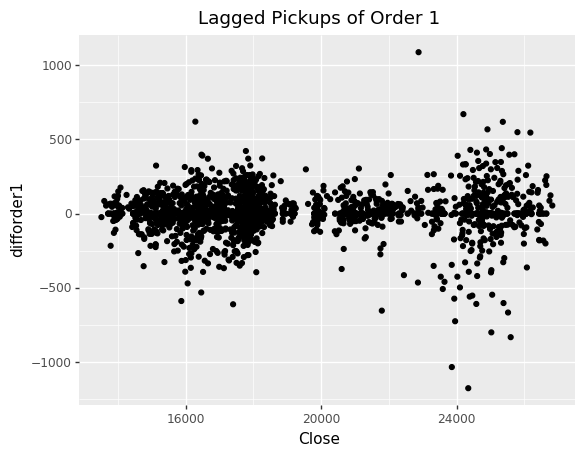

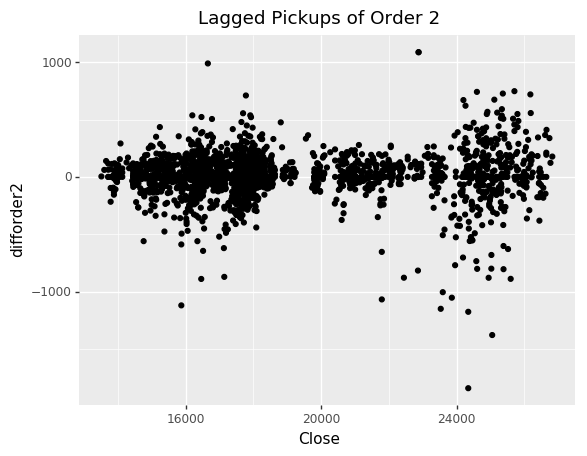

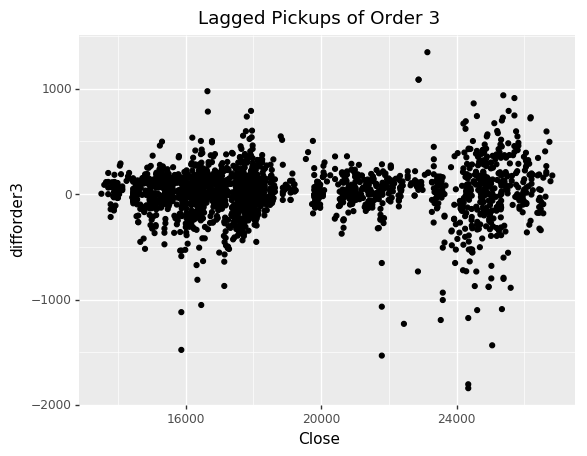

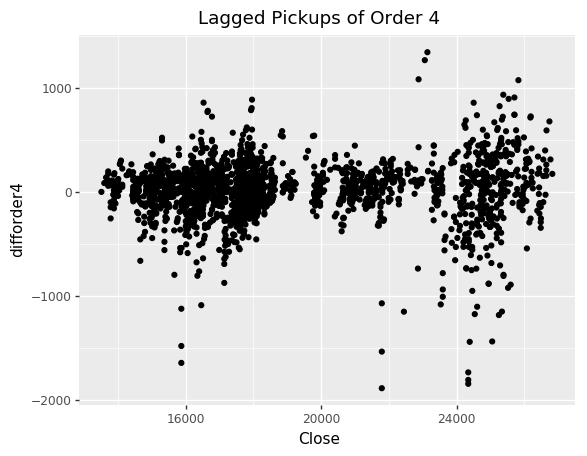

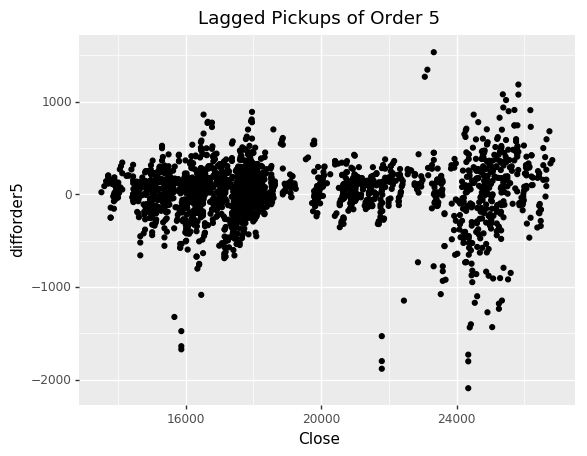

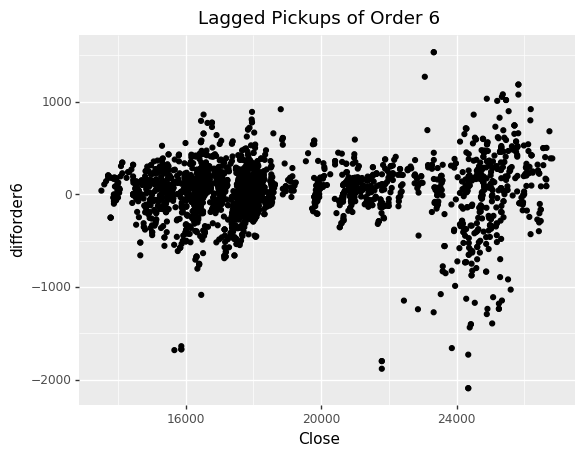

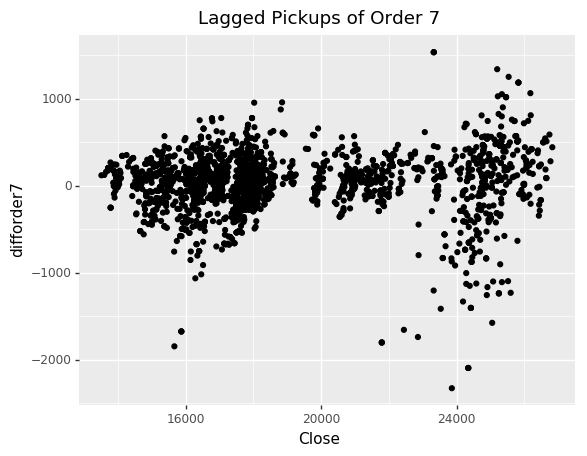

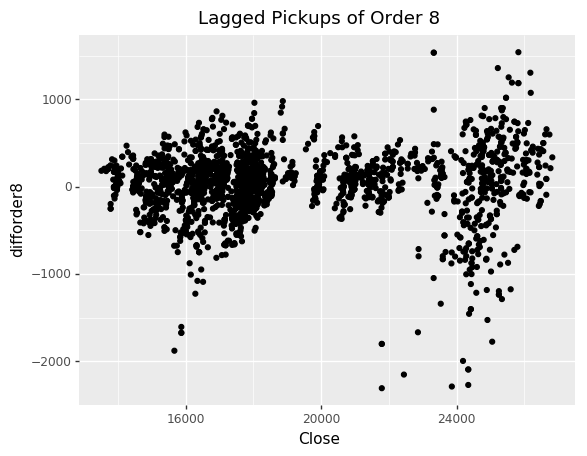

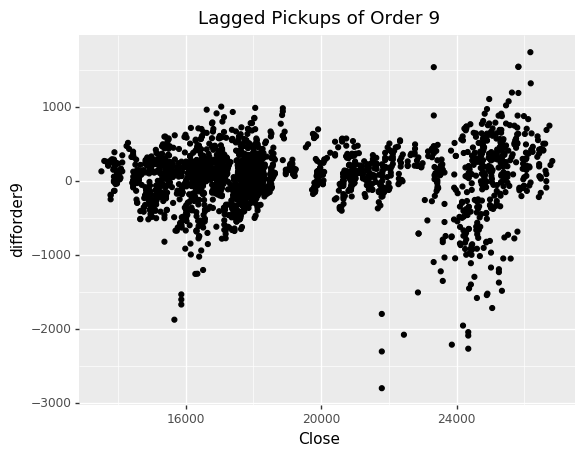

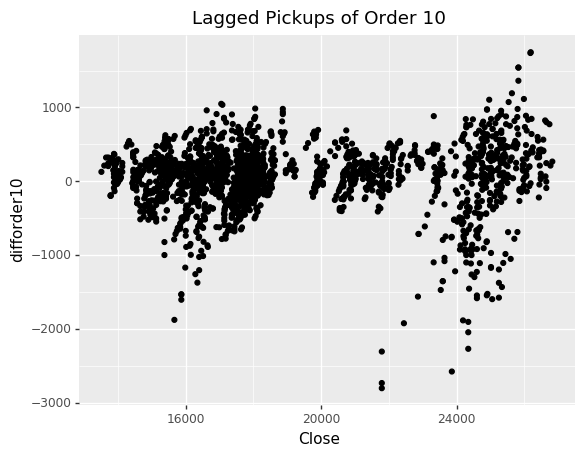

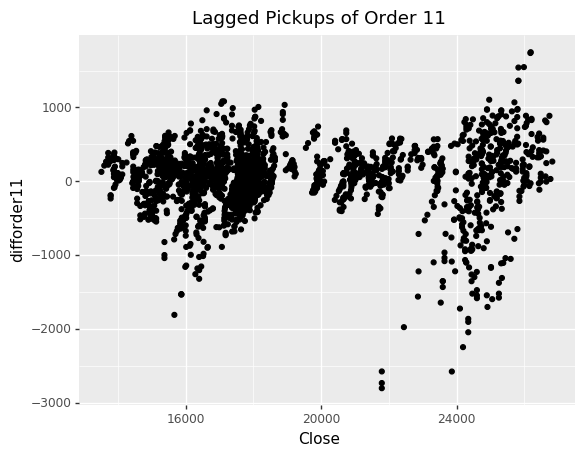

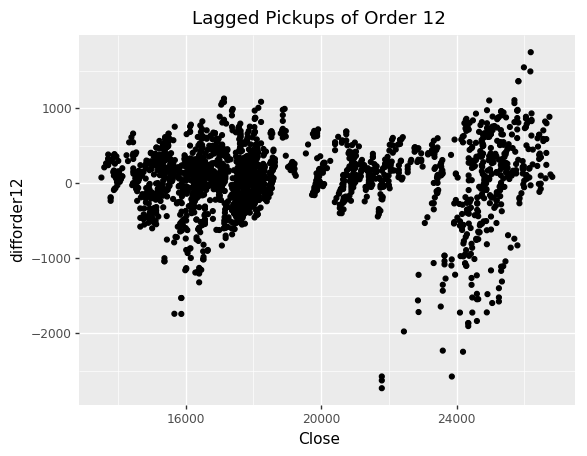

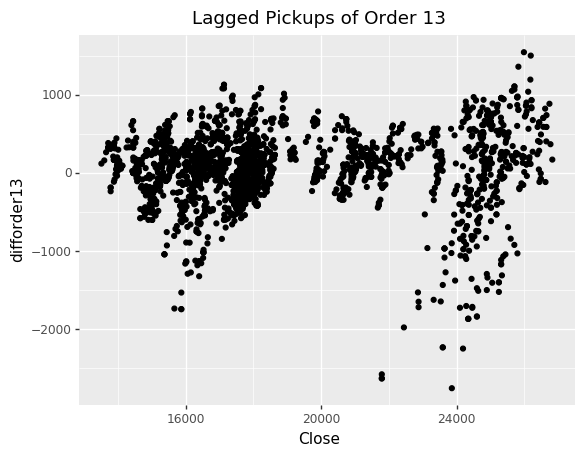

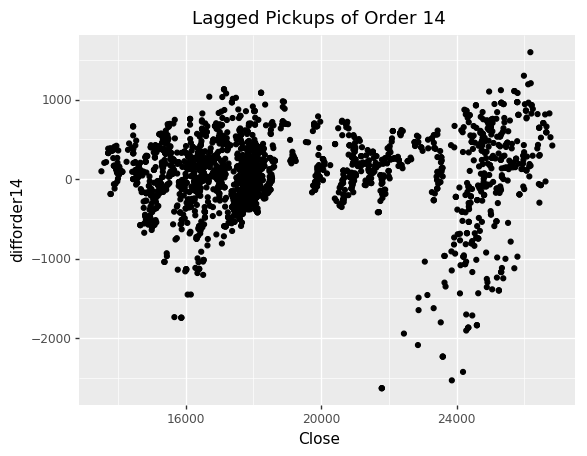

[<ggplot: (-9223363265003569895)>,
 <ggplot: (8771879222620)>,
 <ggplot: (-9223363264975597543)>,
 <ggplot: (8771879178381)>,
 <ggplot: (-9223363264975597403)>,
 <ggplot: (-9223363264975602060)>,
 <ggplot: (8771851207225)>,
 <ggplot: (8771851218345)>,
 <ggplot: (-9223363264975528830)>,
 <ggplot: (8771879225590)>,
 <ggplot: (-9223363264916618131)>,
 <ggplot: (-9223363264916618152)>,
 <ggplot: (-9223363264975509844)>,
 <ggplot: (-9223363264975522146)>]

In [11]:
plots = []

for lag in difforders:
    plots.append((ggplot(djiaclean.dropna()) +
        geom_point(mapping=aes('Close', 'difforder'+str(lag))) +
        labs(title="Lagged Pickups of Order "+str(lag))))
plots

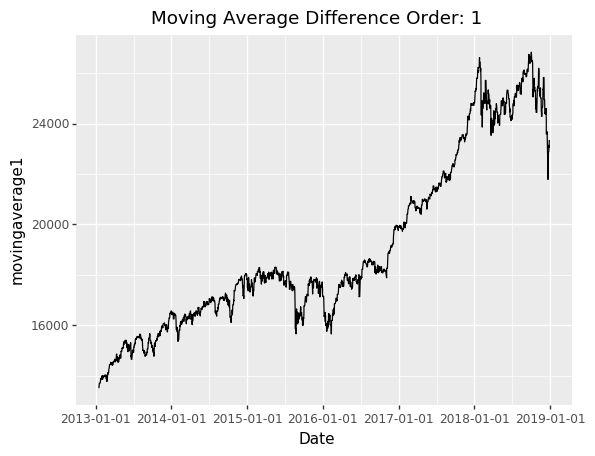

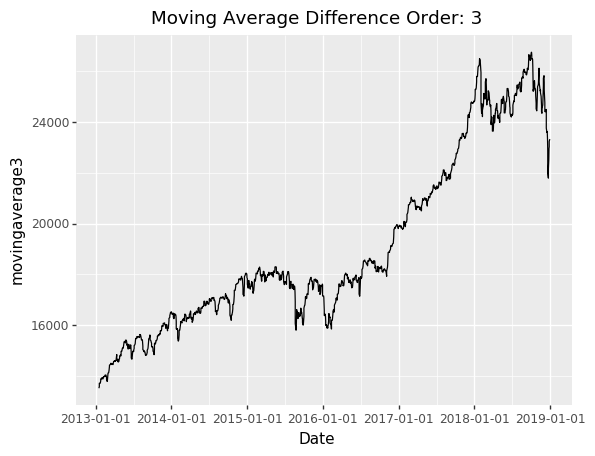

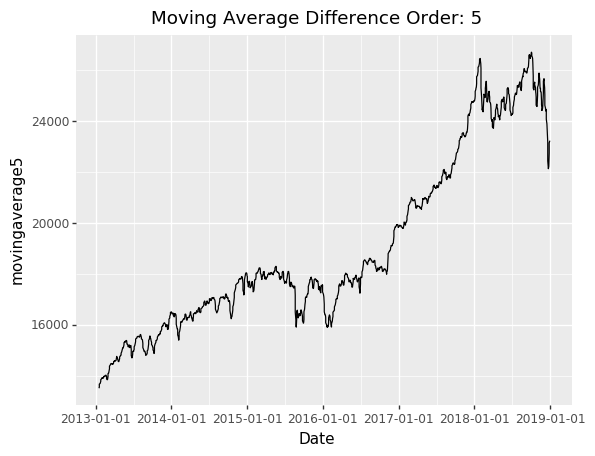

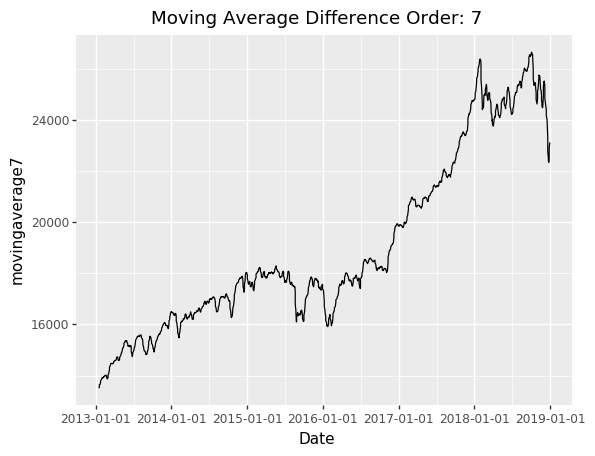

[<ggplot: (8771850837333)>,
 <ggplot: (8771850837445)>,
 <ggplot: (-9223363265003797346)>,
 <ggplot: (-9223363265003671892)>]

In [12]:
maorders = [1, 3, 5, 7] ## Enter your orders here!

plots = []

for order in maorders:
    djiaclean['movingaverage'+str(order)] = djiaclean.Close.rolling(window=order).mean()
    plots.append((ggplot(djiaclean.dropna()) +
       geom_line(mapping=aes('Date','movingaverage'+str(order)))+
       labs(title=("Moving Average Difference Order: " + str(order)))))
    
plots

''

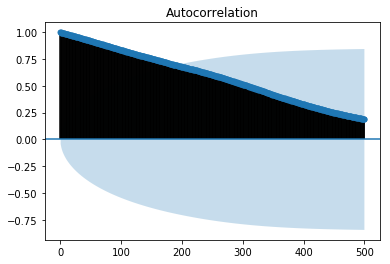

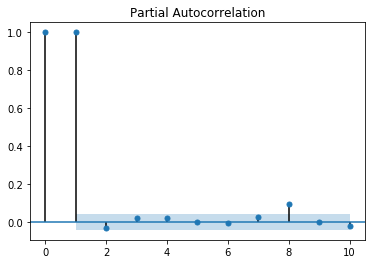

In [13]:
plot_acf(djiaclean.Close, lags=500)
plot_pacf(djiaclean.Close, lags=10)
""

In [14]:
djiatrain = djiaclean[:int(4*len(djiaclean)/5)]
djiatest = djiaclean[int(4*len(djiaclean)/5):]

In [15]:
# Enter your orders below!

model = sarimax.SARIMAX(djiatrain.Close, order=(0, 1, 0))
result = model.fit()
predict_steps = len(djiatest)
djiatest["forecast"] = result.forecast(steps=predict_steps)

/home/infrared/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


MAPE: 6.771799381934097


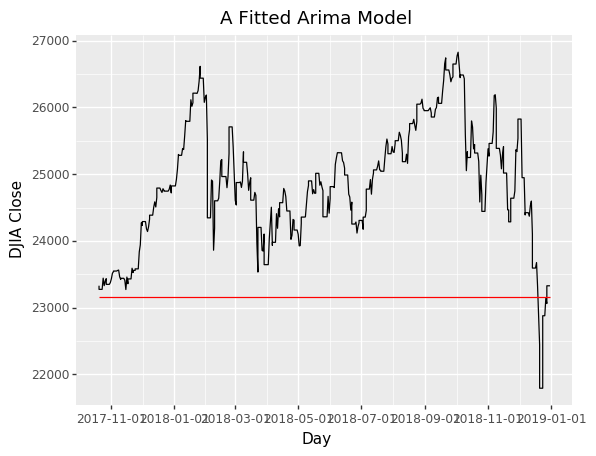

<ggplot: (-9223363265003739048)>

In [16]:
print("MAPE: "+ str(100*np.mean(abs(djiatest.Close - djiatest.forecast)/djiatest.Close)))

(ggplot(djiatest) +
  geom_line(mapping=aes('Date', 'Close')) +
  geom_line(mapping=aes('Date', 'forecast'), color="red") +
  labs(title="A Fitted Arima Model", y="DJIA Close", x="Day"))

In [17]:
prophet_train = djiatrain
prophet_test = djiatest

prophet_train = prophet_train.dropna()[["Date", "Close"]]
prophet_test = prophet_test.dropna()[["Date", "Close"]]

prophet_train.columns = ["ds", "y"]
prophet_test.columns = ["ds", "y"]

In [18]:
m = Prophet(yearly_seasonality=False, daily_seasonality=True)
m.fit(prophet_train)

In [19]:
future = m.make_future_dataframe(periods=len(djiatest), freq='D')
forecast = m.predict(future)

MAPE: 3.696209999183944


/home/infrared/anaconda3/lib/python3.7/site-packages/plotnine/geoms/geom_path.py:74: UserWarning: geom_path: Removed 1751 rows containing missing values.
  warn(msg.format(n1-n2))
/home/infrared/anaconda3/lib/python3.7/site-packages/plotnine/geoms/geom_path.py:74: UserWarning: geom_path: Removed 1751 rows containing missing values.
  warn(msg.format(n1-n2))


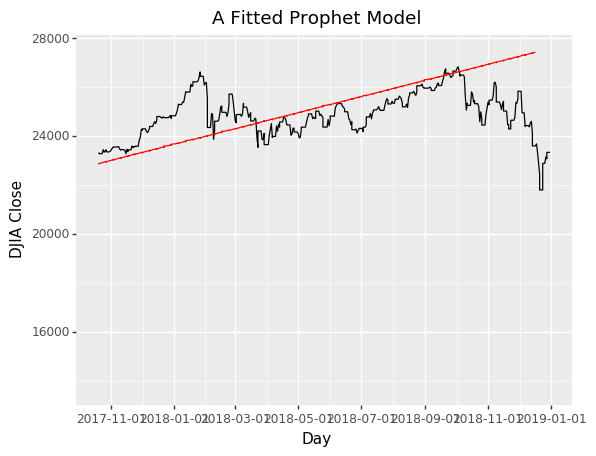

<ggplot: (-9223363265003568573)>

In [20]:
prophetdf = pd.DataFrame({
    'Date': djiatest.Date,
    'Close': djiatest.Close,
    'Forecast': forecast.yhat
})

print("MAPE: "+ str(100*np.mean(abs(djiatest.Close - forecast.yhat)/djiatest.Close)))

(ggplot(prophetdf) +
  geom_line(mapping=aes('Date', 'Close')) +
  geom_line(mapping=aes('Date', 'Forecast'), color="red") +
  labs(title="A Fitted Prophet Model", y="DJIA Close", x="Day"))

In [21]:
import keras as K
import tensorflow
from keras.models import Sequential
from keras.layers import SimpleRNN, LSTM
from keras.layers.core import Dense

Using TensorFlow backend.


In [22]:
num_days_back = 3

for day in range(1, num_days_back+1):
    djia['lag'+str(day)] = djia.Close.shift(day)

In [23]:
colnames = list(map(lambda day: 'lag'+str(day + 1), list(range(num_days_back))))

djiatensor = np.array(djia[colnames])[num_days_back:, ]
djiatarget = np.array(djia.Close)[num_days_back:, ]

In [24]:
cuts = len(djiatrain) - num_days_back

tf_train_x = djiatensor[:cuts].reshape((len(djiatrain) - num_days_back, num_days_back, 1))
tf_train_y = djiatarget[:cuts].reshape((len(djiatrain) - num_days_back, 1))
tf_test_x = djiatensor[cuts:].reshape((len(djiatest), num_days_back, 1))
tf_test_y = djiatarget[cuts:].reshape((len(djiatest), 1))

In [25]:
rnn = Sequential([
    LSTM(units=300, input_shape=(num_days_back, 1), return_sequences=True, activation='relu'),
    LSTM(units=500, input_shape=(num_days_back, 1), return_sequences=True, activation='relu'),
    LSTM(units=300, input_shape=(num_days_back, 1), activation='relu'),
    Dense(200, activation='relu'),
    Dense(100, activation='relu'),
    Dense(1)
])

rnn.compile(optimizer="adam", loss="mean_absolute_percentage_error")
rnn.fit(tf_train_x, tf_train_y, epochs=5, validation_split=0.1)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.


Train on 1573 samples, validate on 175 samples
Epoch 1/5
1573/1573 [==============================] - 5s 3ms/step - loss: 30.6570 - val_loss: 2.5353
Epoch 2/5
1573/1573 [==============================] - 2s 1ms/step - loss: 1.7507 - val_loss: 1.1425
Epoch 3/5
1573/1573 [==============================] - 2s 1ms/step - loss: 1.7132 - val_loss: 2.0536
Epoch 4/5
1573/1573 [==============================] - 2s 1ms/step - loss: 2.2376 - val_loss: 2.9700
Epoch 5/5
1573/1573 [==============================] - 2s 1ms/step - loss: 1.6592 - val_loss: 0.5825


438/438 [==============================] - 0s 322us/step
MAPE:0.8026924051650582


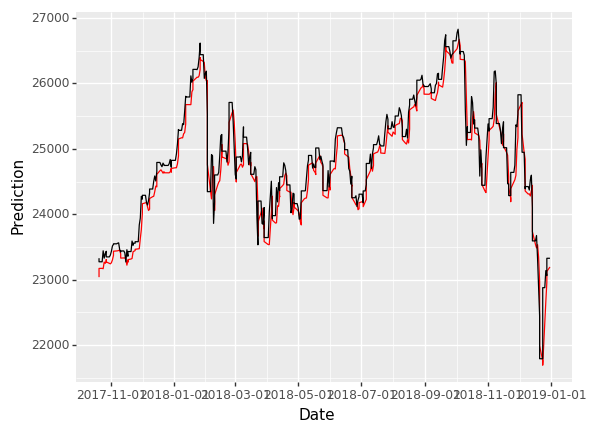

<ggplot: (8771720153650)>

In [26]:
print("MAPE:" + str(rnn.evaluate(tf_test_x, tf_test_y)))

rnnpredictions = rnn.predict(tf_test_x)
predictionsdf = pd.DataFrame({"Prediction":list(rnnpredictions[:,0]), "Actual":djiatest.Close,
                              "Date":djiatest.Date})
(ggplot(predictionsdf) +
    geom_line(mapping=aes('Date', 'Prediction'), color='red') +
    geom_line(mapping=aes('Date', 'Actual')))